#BERT

In [1]:
!pip install pandas
!pip install numpy
!pip install matplotlib
!pip install seaborn
!pip install sklearn
!pip install tensorflow
!pip install transformers
!pip install nltk

In [ ]:
pip uninstall transformers y


In [2]:
pip install tensorflow-text

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tensorflow-hub

Note: you may need to restart the kernel to use updated packages.


### Import the required libraries

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
import nltk
import warnings
warnings.simplefilter("ignore")

### Read and Inspect the Data

In [5]:
ed = pd.read_csv('/Users/izabellamartirosyan/Desktop/tweet_emotions.csv')


In [6]:
ed.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [7]:
ed.shape

(40000, 3)

In [8]:
ed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


There are 40000 rows and 3 columns in the dataset. For text classification, we are interested in the content and sentiment column.

In [9]:
ed.duplicated().sum()

0

There are no duplicates and there can't be outliers since both are text columns.

In [10]:
ed1 = ed.copy() #make a seperate copy of the original dataframe

In [11]:
#Check for the unique values in the sentiment column
ed1.sentiment.unique()

array(['empty', 'sadness', 'enthusiasm', 'neutral', 'worry', 'surprise',
       'love', 'fun', 'hate', 'happiness', 'boredom', 'relief', 'anger'],
      dtype=object)

In [12]:
ed1.sentiment.nunique()

13

In [13]:
ed1.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

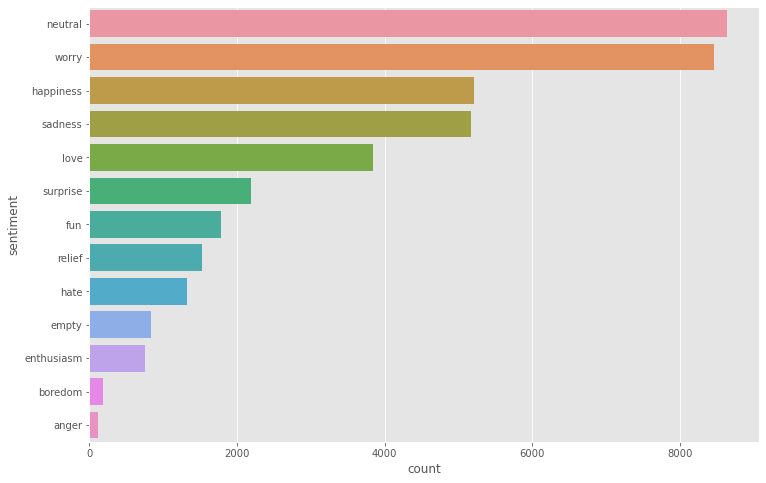

In [14]:
plt.figure(figsize = (12,8))
sns.countplot(y=ed1.sentiment,data = ed1,order = ed1.sentiment.value_counts().index)

Grouping together hate and anger under the label hate/anger and empty and boredom under the label empty/bore.

In [15]:
def labels(sentiment):
    if sentiment=='hate' or sentiment == 'anger':
        return 'hate/anger'
    elif sentiment == 'empty' or sentiment ==  'boredom':
        return 'empty/boredom'
    else:
        return sentiment

ed1['sentiment'] = ed1.apply(lambda x: labels(x['sentiment']),axis=1)

In [16]:
ed1.sentiment.value_counts()

neutral          8638
worry            8459
happiness        5209
sadness          5165
love             3842
surprise         2187
fun              1776
relief           1526
hate/anger       1433
empty/boredom    1006
enthusiasm        759
Name: sentiment, dtype: int64

In [17]:
#check random tweet from content series
ed1.content[99]

"@ cayogial i wanted to come to BZ this summer :/ not so sure anymore... a teacher's life in the summer SUCKS"

In [18]:
ed1.sentiment[99]

'hate/anger'

In [19]:
from nltk.tokenize import TweetTokenizer
tt = TweetTokenizer()
ed1['tokenize_content'] = ed1.content.str.lower().apply(tt.tokenize)

In [20]:
ed1.tokenize_content[99]

['@',
 'cayogial',
 'i',
 'wanted',
 'to',
 'come',
 'to',
 'bz',
 'this',
 'summer',
 ':/',
 'not',
 'so',
 'sure',
 'anymore',
 '...',
 'a',
 "teacher's",
 'life',
 'in',
 'the',
 'summer',
 'sucks']

In [21]:
#nltk.download('wordnet')

In [22]:
from nltk.stem import WordNetLemmatizer 
def lemmatize_text(text):
    lemmatizer = WordNetLemmatizer()
    return [lemmatizer.lemmatize(w) for w in text]
    
ed1['tokenize_lemmatized_content'] = ed1['tokenize_content'].apply(lemmatize_text)

In [23]:
ed1.tokenize_lemmatized_content[99]

['@',
 'cayogial',
 'i',
 'wanted',
 'to',
 'come',
 'to',
 'bz',
 'this',
 'summer',
 ':/',
 'not',
 'so',
 'sure',
 'anymore',
 '...',
 'a',
 "teacher's",
 'life',
 'in',
 'the',
 'summer',
 'suck']

In [24]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/izabellamartirosyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [25]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
ed1['text']=ed1.tokenize_lemmatized_content.apply(lambda x: [item for item in x if item not in stop])

In [26]:
ed1.text[99]

['@',
 'cayogial',
 'wanted',
 'come',
 'bz',
 'summer',
 ':/',
 'sure',
 'anymore',
 '...',
 "teacher's",
 'life',
 'summer',
 'suck']

In [27]:
ed1.head()

,tweet_id,sentiment,content,tokenize_content,tokenize_lemmatized_content,text
0,1956967341,empty/boredom,@tiffanylue i know i was listenin to bad habi...,"[@tiffanylue, i, know, i, was, listenin, to, b...","[@tiffanylue, i, know, i, wa, listenin, to, ba...","[@tiffanylue, know, wa, listenin, bad, habit, ..."
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...,"[layin, n, bed, with, a, headache, ughhhh, ......","[layin, n, bed, with, a, headache, ughhhh, ......","[layin, n, bed, headache, ughhhh, ..., waitin,..."
2,1956967696,sadness,Funeral ceremony...gloomy friday...,"[funeral, ceremony, ..., gloomy, friday, ...]","[funeral, ceremony, ..., gloomy, friday, ...]","[funeral, ceremony, ..., gloomy, friday, ...]"
3,1956967789,enthusiasm,wants to hang out with friends SOON!,"[wants, to, hang, out, with, friends, soon, !]","[want, to, hang, out, with, friend, soon, !]","[want, hang, friend, soon, !]"
4,1956968416,neutral,@dannycastillo We want to trade with someone w...,"[@dannycastillo, we, want, to, trade, with, so...","[@dannycastillo, we, want, to, trade, with, so...","[@dannycastillo, want, trade, someone, ha, hou..."


In [28]:
ed1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   tweet_id                     40000 non-null  int64 
 1   sentiment                    40000 non-null  object
 2   content                      40000 non-null  object
 3   tokenize_content             40000 non-null  object
 4   tokenize_lemmatized_content  40000 non-null  object
 5   text                         40000 non-null  object
dtypes: int64(1), object(5)
memory usage: 1.8+ MB


In [29]:
ed1.text

0        [@tiffanylue, know, wa, listenin, bad, habit, ...
1        [layin, n, bed, headache, ughhhh, ..., waitin,...
2            [funeral, ceremony, ..., gloomy, friday, ...]
3                            [want, hang, friend, soon, !]
4        [@dannycastillo, want, trade, someone, ha, hou...
                               ...                        
39995                                   [@johnlloydtaylor]
39996                           [happy, mother, day, love]
39997    [happy, mother's, day, mommy, ,, woman, man, l...
39998    [@niariley, wassup, beautiful, !, !, !, follow...
39999    [@mopedronin, bullet, train, tokyo, gf, visiti...
Name: text, Length: 40000, dtype: object

In [30]:
ed1['text'] = ed1['text'].apply(lambda x: str(x).replace(',','').lstrip('[').rstrip(']')).str.replace("'","")

In [31]:
ed2 = ed1[['text','sentiment']].copy()

In [32]:
ed2.head()

,text,sentiment
0,@tiffanylue know wa listenin bad habit earlier...,empty/boredom
1,layin n bed headache ughhhh ... waitin call ...,sadness
2,funeral ceremony ... gloomy friday ...,sadness
3,want hang friend soon !,enthusiasm
4,@dannycastillo want trade someone ha houston t...,neutral


In [33]:
ed2.shape

(40000, 2)

### Split into Training and Test dataset

In [34]:
from sklearn.model_selection import train_test_split

In [35]:
X_train, X_test, y_train_unenc, y_test_unenc = train_test_split(\
    ed2.text,ed2.sentiment,test_size = 0.35,stratify = ed1.sentiment )

In [36]:
print(X_train.shape,y_train_unenc.shape,X_test.shape,y_test_unenc.shape)

(26000,) (26000,) (14000,) (14000,)


In [37]:
X_train.head()

37394                            @michellecorydon thanks !
18356                                      youtube working
24473    @emily_morden .. "richards" . "ill" see / get ...
27562                     "lets" continue productive today
2784                   @redjotter  . seems cruel condition
Name: text, dtype: object

In [38]:
y_train_unenc.head()

37394    happiness
18356      sadness
24473    happiness
27562      neutral
2784         worry
Name: sentiment, dtype: object

In [39]:
y_train_unenc.value_counts()

neutral          5615
worry            5498
happiness        3386
sadness          3357
love             2497
surprise         1422
fun              1154
relief            992
hate/anger        932
empty/boredom     654
enthusiasm        493
Name: sentiment, dtype: int64

In [40]:
y_test_unenc.value_counts()

neutral          3023
worry            2961
happiness        1823
sadness          1808
love             1345
surprise          765
fun               622
relief            534
hate/anger        501
empty/boredom     352
enthusiasm        266
Name: sentiment, dtype: int64

In [41]:
print(5615/y_train_unenc.shape[0],3023/y_test_unenc.shape[0])

0.21596153846153845 0.21592857142857144


In [42]:
print(493/y_train_unenc.shape[0],266/y_test_unenc.shape[0])

0.01896153846153846 0.019


##### Preprocessing the y_train_unenc and y_test_unenc

There 11 type of emotions present in the sentiment column. For feeding it into deep neural network, we will first convert them into labels and then encode it using one hot encoders.

In [43]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()

In [44]:
y_train_enc = label_encoder.fit_transform(y_train_unenc)
y_test_enc = label_encoder.fit_transform(y_test_unenc)

In [45]:
print(np.unique(y_train_enc))

[ 0  1  2  3  4  5  6  7  8  9 10]


In [46]:
y_train_enc

array([3, 8, 3, ..., 1, 6, 2])

In [47]:
conda install keras

Solving environment: \ 
The environment is inconsistent, please check the package plan carefully
The following packages are causing the inconsistency:

  - defaults/osx-64::matplotlib-base==3.2.2=py38h5670ca0_0
  - defaults/osx-64::mkl_random==1.1.1=py38h959d312_0
  - defaults/osx-64::statsmodels==0.11.1=py38haf1e3a3_0
  - defaults/osx-64::astropy==4.0.1.post1=py38h01d97ff_1
  - defaults/osx-64::bottleneck==1.3.2=py38hf1fa96c_1
  - defaults/noarch::numpydoc==1.1.0=py_0
  - defaults/osx-64::conda-build==3.18.11=py38_0
  - defaults/noarch::imageio==2.9.0=py_0
  - defaults/osx-64::pywavelets==1.1.1=py38h1de35cc_0
  - defaults/osx-64::mkl_fft==1.1.0=py38hc64f4ea_0
  - defaults/noarch::anaconda-project==0.8.4=py_0
  - defaults/osx-64::bokeh==2.1.1=py38_0
  - defaults/osx-64::scipy==1.5.0=py38hbab996c_0
  - conda-forge/osx-64::conda==4.12.0=py38h50d1736_0
  - defaults/osx-64::patsy==0.5.1=py38_0
  - defaults/osx-64::_ipyw_jlab_nb_ext_conf==0.1.0=py38_0
  - defaults/osx-64::anaconda-client==1

In [48]:
pip install np_utils

Note: you may need to restart the kernel to use updated packages.


In [49]:
!pip install keras.utils

Processing ./Library/Caches/pip/wheels/2f/e9/19/d3d310a06735013bf467216222ebb92b1158c5d3ae006bf92a/keras_utils-1.0.13-py3-none-any.whl


In [54]:
from transformers import BertTokenizer

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: SystemError: <built-in method __contains__ of dict object at 0x7fadf5b24340> returned a result with an error set

##### Import Bert PreProcessor and Bert Encoder

In [53]:
from transformers import AutoTokenizer,TFBertModel
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')
bert = TFBertModel.from_pretrained('bert-base-cased')

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: SystemError: <built-in method __contains__ of dict object at 0x7fadf5a662c0> returned a result with an error set

In [ ]:
max_len = 70

In [ ]:
# Tokenize the input (takes some time) 
# here tokenizer using from bert-base-cased
x_train = tokenizer(
    text=X_train.tolist(),
    add_special_tokens=True,
    max_length = max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
x_test = tokenizer(
    text=X_test.tolist(),
    add_special_tokens=True,
    max_length = max_len,
    truncation=True,
    padding=True, 
    return_tensors='tf',
    return_token_type_ids = False,
    return_attention_mask = True,
    verbose = True)

In [ ]:
input_ids = x_train['input_ids']
attention_mask = x_train['attention_mask']

### Model Building

In [55]:
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.initializers import TruncatedNormal
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.metrics import CategoricalAccuracy

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

ImportError: SystemError: <built-in method __contains__ of dict object at 0x7fadf5b55b40> returned a result with an error set

In [ ]:
# Bert layers
input_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_ids")
input_mask = Input(shape=(max_len,), dtype=tf.int32, name="attention_mask")
embeddings = bert(input_ids,attention_mask = input_mask)[0] 
out = tf.keras.layers.GlobalMaxPool1D()(embeddings)
out = Dense(128, activation='relu')(out)
out = tf.keras.layers.Dropout(0.1)(out)
out = Dense(64,activation = 'relu')(out)
y = Dense(11,activation = 'softmax')(out)
model = tf.keras.Model(inputs=[input_ids, input_mask], outputs=y)
model.layers[2].trainable = True

In [ ]:
model.summary()

In [ ]:
optimizer = Adam(
    learning_rate=5e-05, # this learning rate is for bert model , taken from huggingface website 
    epsilon=1e-08,
    decay=0.01,
    clipnorm=1.0)
# Set loss and metrics
loss =CategoricalCrossentropy(from_logits = True)
metric = CategoricalAccuracy("balanced_accuracy"),
# Compile the model
model.compile(
    optimizer = optimizer,
    loss = loss, 
    metrics = metric)

In [ ]:
train_history = model.fit(
    x ={'input_ids':x_train['input_ids'],'attention_mask':x_train['attention_mask']} ,
    y = y_train,
    validation_data = (
    {'input_ids':x_test['input_ids'],'attention_mask':x_test['attention_mask']}, y_test
    ),
  epochs=1,
  batch_size = 128
)

In [ ]:
model.evaluate(X_test, y_test)

In [ ]:
y_predicted = model.predict(X_test)

In [ ]:
y_predict=np.argmax(y_predicted, axis = 1)

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_test_enc, y_predict))

In [ ]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_enc, y_predict)

In [ ]:
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')